# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit,
                           plot_parameters_kde)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ikur_generic import ikur as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [8]:
limits = dict(g_Kur=(0, 1),
              Vhalf_a=(-100,100),
              k_a=(0,50),
              c_ba=(0,10),
              c_aa=(0,100),
              sigma_a=(0,100),
              Vmax_a=(-100,100),
              Vhalf_i=(-200,200),
              k_i=(-50,0),
              c_bi=(0,10000),
              c_ai=(0,10000),
              sigma_i=(0,20),
              Vmax_i=(-100,100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [63]:
parameters = ['ikur.'+k for k in limits.keys()]

In [64]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

DEBUG:ABC:ion channel weights: {0: 0.5258873292334321, 1: 0.5258873292334321, 2: 0.5258873292334321, 3: 0.4995929627717598, 4: 0.4114294987532165, 5: 0.3681211304634045, 6: 0.4114294987532165, 7: 0.4114294987532165, 8: 0.3681211304634025, 9: 0.3885723043780368, 10: 0.3885723043780368, 11: 0.3681211304634025, 12: 0.29142922828352713, 13: 0.8154291198404024, 14: 0.5708773676507556, 15: 0.634507863567063, 16: 0.5192914070433957, 17: 0.5708773676507556, 18: 0.5706977711634583, 19: 0.5712368999490637, 20: 1.1938458383673252, 21: 1.1938458383673252, 22: 1.1938458383673252, 23: 1.1938458383673252, 24: 1.1938458383673252, 25: 1.1938458383673252, 26: 1.1938458383673252, 27: 1.1938458383673252, 28: 1.1938458383673252, 29: 1.8517988982667652, 30: 1.8517988982667652, 31: 1.8517988982667652, 32: 1.8517988982667652, 33: 1.8517988982667652, 34: 1.8517988982667652, 35: 1.8517988982667652, 36: 1.8517988982667652, 37: 1.8517988982667652, 38: 1.8517988982667652}


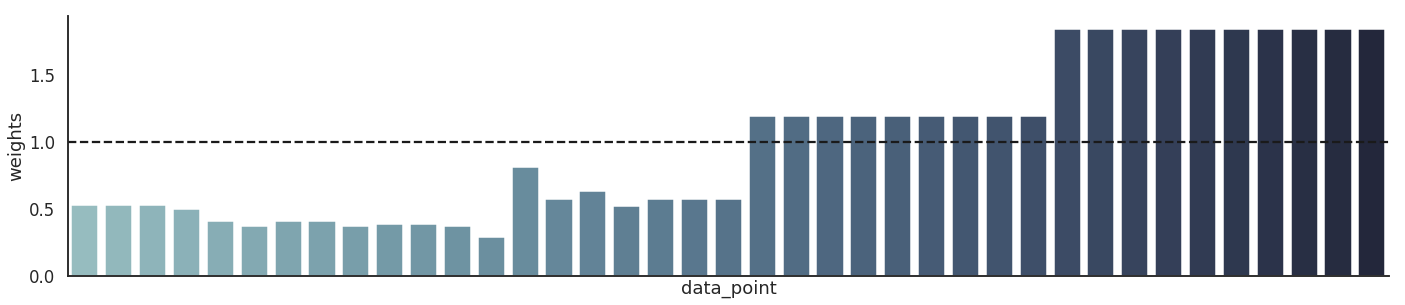

In [65]:
from ionchannelABC import plot_distance_weights
sns.set_context('talk')
grid = plot_distance_weights(model, distance_fn)
grid.savefig('results/ikur-generic/dist_weights.pdf')

In [70]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.05,
    n_samples=1000)

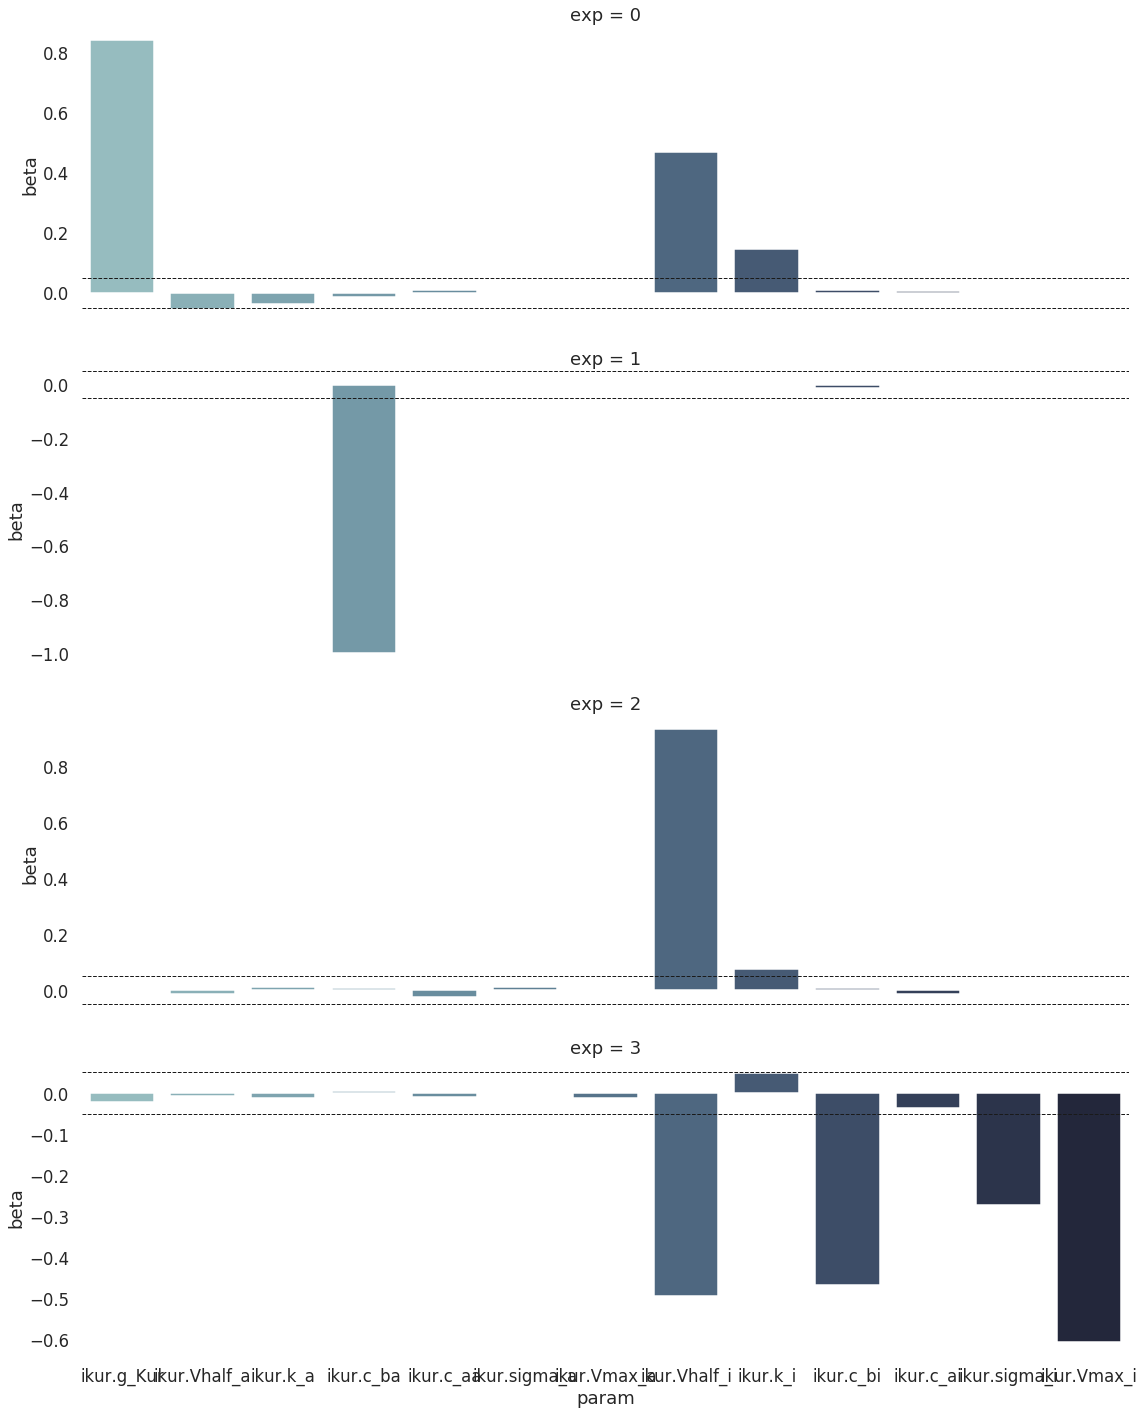

In [71]:
sns.set_context('talk')
grid1 = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

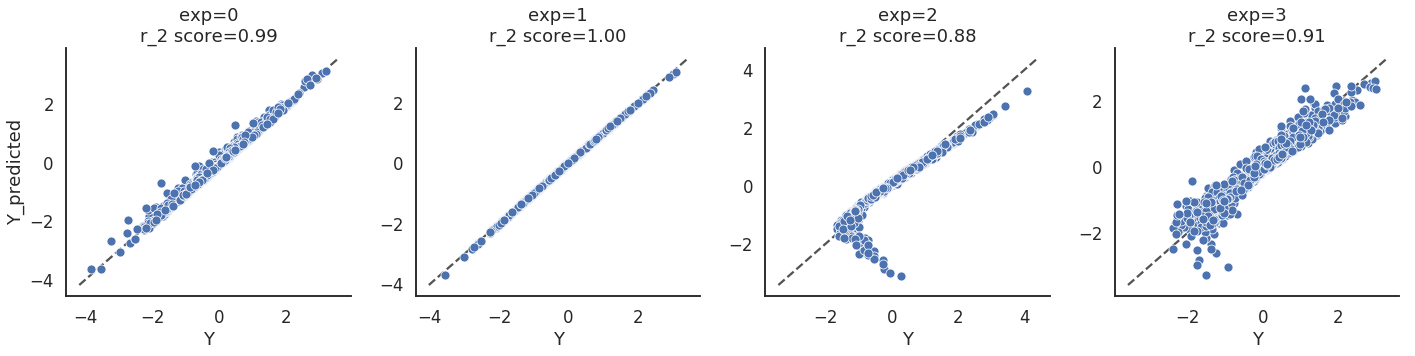

In [72]:
grid2 = plot_regression_fit(regression_fit, r2)

In [73]:
grid1.savefig('results/ikur-generic/sensitivity.pdf')
grid2.savefig('results/ikur-generic/sensitivity_fit.pdf')

# Initialise pyabc database

In [9]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ikur-generic.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ikur-generic.db


In [10]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [11]:
from pyabc.populationstrategy import ConstantPopulationSize

In [12]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=ConstantPopulationSize(1000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=1000,
             #    mean_cv=0.2,
             #    max_population_size=1000,
             #    min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=6),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.5258873292334321, 1: 0.5258873292334321, 2: 0.5258873292334321, 3: 0.4995929627717598, 4: 0.4114294987532165, 5: 0.3681211304634045, 6: 0.4114294987532165, 7: 0.4114294987532165, 8: 0.3681211304634025, 9: 0.3885723043780368, 10: 0.3885723043780368, 11: 0.3681211304634025, 12: 0.29142922828352713, 13: 0.8154291198404024, 14: 0.5708773676507556, 15: 0.634507863567063, 16: 0.5192914070433957, 17: 0.5708773676507556, 18: 0.5706977711634583, 19: 0.5712368999490637, 20: 1.1938458383673252, 21: 1.1938458383673252, 22: 1.1938458383673252, 23: 1.1938458383673252, 24: 1.1938458383673252, 25: 1.1938458383673252, 26: 1.1938458383673252, 27: 1.1938458383673252, 28: 1.1938458383673252, 29: 1.8517988982667652, 30: 1.8517988982667652, 31: 1.8517988982667652, 32: 1.8517988982667652, 33: 1.8517988982667652, 34: 1.8517988982667652, 35: 1.8517988982667652, 36: 1.8517988982667652, 37: 1.8517988982667652, 38: 1.8517988982667652}
DEBUG:Epsilon:init quantile_epsilon initia

In [13]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-11-20 11:06:51.529563, end_time=None)>
INFO:Epsilon:initial epsilon is 46.80338811651279


In [ ]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:30 eps:1.0558533908480006
DEBUG:ABC:now submitting population 30
DEBUG:ABC:population 30 done
DEBUG:ABC:
total nr simulations up to t =30 is 579848
DEBUG:Epsilon:new eps, t=31, eps=1.0171558508865615
INFO:ABC:t:31 eps:1.0171558508865615
DEBUG:ABC:now submitting population 31
DEBUG:ABC:population 31 done
DEBUG:ABC:
total nr simulations up to t =31 is 600158
DEBUG:Epsilon:new eps, t=32, eps=0.9891128464338145
INFO:ABC:t:32 eps:0.9891128464338145
DEBUG:ABC:now submitting population 32
DEBUG:ABC:population 32 done
DEBUG:ABC:
total nr simulations up to t =32 is 615603
DEBUG:Epsilon:new eps, t=33, eps=0.9542030869775429
INFO:ABC:t:33 eps:0.9542030869775429
DEBUG:ABC:now submitting population 33
DEBUG:ABC:population 33 done
DEBUG:ABC:
total nr simulations up to t =33 is 634712
DEBUG:Epsilon:new eps, t=34, eps=0.9195021808770236
INFO:ABC:t:34 eps:0.9195021808770236
DEBUG:ABC:now submitting population 34
DEBUG:ABC:population 34 done
DEBUG:ABC:
total nr simulations up to t =34 is 6508

# Results analysis

In [35]:
db_path = ('sqlite:////scratch/cph211/ion-channel-ABC/docs/examples/results/ikur-generic/hl-1_ikur-generic.db')
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-11-20 11:06:51.529563, end_time=2018-11-21 00:13:04.996753)>]

In [36]:
history.id = 1

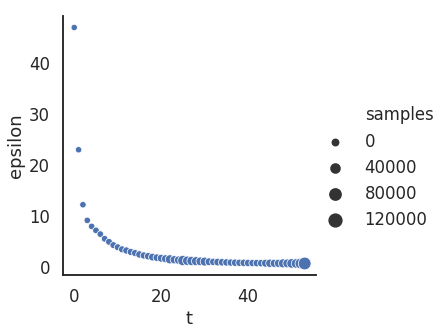

In [37]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])

In [38]:
grid.savefig('results/ikur-generic/eps_evolution.pdf')

In [39]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


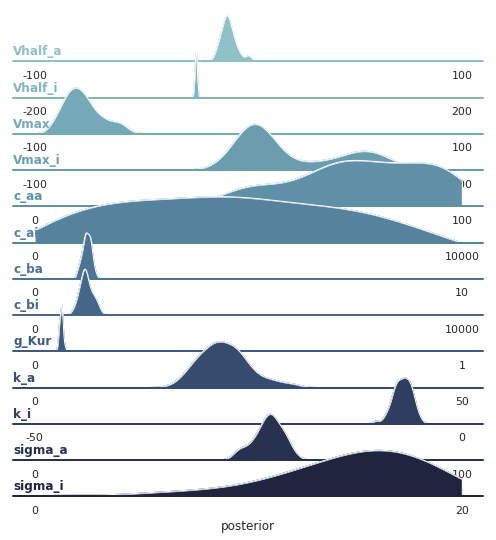

In [41]:
g = plot_parameters_kde(df, w, limits, aspect=12, height=0.6)

In [69]:
df.describe()

name,Vhalf_a,Vhalf_i,Vmax_a,Vmax_i,c_aa,c_ai,c_ba,c_bi,g_Kur,k_a,k_i,sigma_a,sigma_i
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-9.524083,-48.671612,-76.315329,24.498649,74.453591,4824.810234,1.233138,1219.117981,0.062341,22.051429,-6.935870,54.276349,14.038502
std,3.134753,0.951844,8.537954,25.998164,15.646548,2482.601116,0.087616,153.396430,0.003706,2.477934,0.904783,3.197435,3.904168
min,-16.806492,-51.527652,-93.927751,-9.866417,34.597868,116.527926,0.970877,798.538054,0.053289,15.090461,-10.080906,44.299479,0.561320
25%,-11.727736,-49.328215,-82.731259,2.305565,62.800932,2872.197897,1.171430,1113.248022,0.059601,20.435052,-7.605252,52.155926,11.966539
50%,-9.839066,-48.632164,-77.869031,7.625076,75.696029,4720.153125,1.233748,1210.312552,0.062038,21.863864,-6.869317,54.604829,14.644471
75%,-7.660743,-48.048764,-70.575893,53.502875,87.788873,6633.080007,1.295913,1328.307017,0.064740,23.557299,-6.337088,56.590083,16.976335
max,2.392845,-46.152318,-49.932501,78.535998,99.998340,9976.515311,1.484978,1624.519987,0.075019,30.629284,-4.437640,62.191202,19.997786


In [43]:
g.savefig('results/ikur-generic/parameters_kde.pdf')

# Samples for quantitative analysis

In [44]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [46]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=20)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

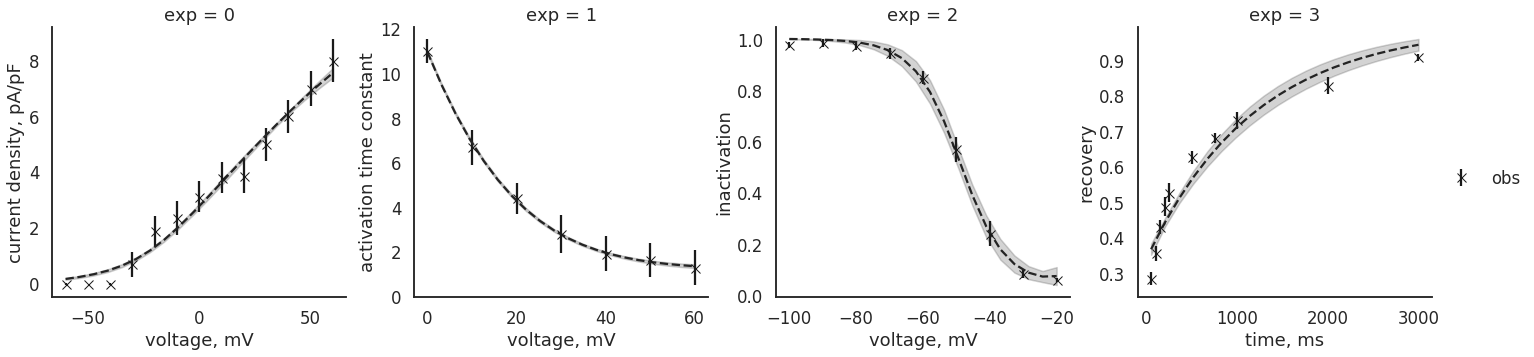

In [47]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]
ylabels = ["current density, pA/pF", "activation time constant", "inactivation", "recovery"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [48]:
g.savefig('results/ikur-generic/ikur_sim_results.pdf')

In [50]:
# Activation kinetics measurements from Xu
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_single_exp(group):
    def single_exp(V, a, b, c):
        return a + b*(np.exp(-V/c))
    guess = (10, 5, 10)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_single_exp).apply(pd.Series)

In [52]:
print(output.mean())
print(output.std())

0     0.853051
1    10.236244
2    18.368860
dtype: float64
0    0.120288
1    0.122073
2    0.642241
dtype: float64


In [53]:
import scipy.stats as st
a = output[0].tolist()
rv = st.rv_discrete(values=(a, [1/len(a),]*len(a)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 0.8601165728615298
95% CI: (0.602327630411518, 1.1126127432247241)


In [54]:
b = output[1].tolist()
rv = st.rv_discrete(values=(b, [1/len(b),]*len(b)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 10.232292765941244
95% CI: (9.937099175752598, 10.454644578186096)


In [55]:
c = output[2].tolist()
rv = st.rv_discrete(values=(c, [1/len(c),]*len(c)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 18.378332706415183
95% CI: (17.226704580395584, 19.76308488182553)


In [56]:
# Parameters of Boltzmann fit to inactivation
grouped = samples[samples.exp==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, Shalf):
        return 1/(1+np.exp((V-Vhalf)/Shalf))
    guess = (50, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [57]:
print(output.mean())
print(output.std())

0   -48.104685
1     7.598993
dtype: float64
0    1.093067
1    1.305122
dtype: float64


In [58]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -47.9607315400544
95% CI: (-50.560941120295396, -45.95442387035424)


In [59]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 7.3722914285633525
95% CI: (5.696118722765498, 10.872423229061333)


In [60]:
# Recovery dynamics from Brouillette
grouped = samples[samples.exp==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(V, a, b, c):
        return a + b*(np.exp(-V/c))
    guess = (1, -1, 300)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt
output = grouped.apply(fit_single_exp).apply(pd.Series)

In [61]:
print(output.mean())
print(output.std())

0       0.999785
1      -0.658967
2    1222.375836
dtype: float64
0      0.000218
1      0.018359
2    153.948273
dtype: float64


In [62]:
tau = output[2].tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 1202.4211057815367
95% CI: (932.4394856927208, 1508.0885914935072)
